# Credit Worthiness of a Customer

In [100]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Data Pre-processing
1. Reading the Dataset (Source : https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).
2. Renaming and dropping the redundant collumns.
3. Cleaning the Dataset for some inconsistency.


In [101]:
data = pd.read_excel("/content/drive/My Drive/default of credit card clients.xls")
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [102]:
data.rename(columns={"default payment next month": "Default"}, inplace=True)
data.drop('ID', axis = 1, inplace =True) # drop column "ID"
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [103]:
# Separating features and target
y = data.Default     # target default=1 or non-default=0
features = data.drop('Default', axis = 1, inplace = False)
features

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


In [104]:
data['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [105]:
data['EDUCATION']=np.where(data['EDUCATION'] == 5, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 6, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 0, 4, data['EDUCATION'])
data['EDUCATION'].unique()

array([2, 1, 3, 4])

In [106]:
data['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [107]:
data['MARRIAGE']=np.where(data['MARRIAGE'] == 0, 3, data['MARRIAGE'])
data['MARRIAGE'].unique()

array([1, 2, 3])

###Data Visualizaton
1. Calculating the target (Default) percentage (Yes, No).
2. Describing the data for mean, median, etc for all individual collumns.
3. Graphically Representing the dependency of various collumns on target (Default).

In [108]:
# The frequency of defaults
yes = data.Default.sum()
no = len(data)-yes

# Percentage
yes_perc = round(yes/len(data)*100, 1)
no_perc = round(no/len(data)*100, 1)

print("Defaults : ", yes_perc)
print ("Non-Defaults : ", no_perc)

Defaults :  22.1
Non-Defaults :  77.9


In [109]:
print(data.describe().T)

             count           mean  ...        75%        max
LIMIT_BAL  30000.0  167484.322667  ...  240000.00  1000000.0
SEX        30000.0       1.603733  ...       2.00        2.0
EDUCATION  30000.0       1.842267  ...       2.00        4.0
MARRIAGE   30000.0       1.557267  ...       2.00        3.0
AGE        30000.0      35.485500  ...      41.00       79.0
PAY_0      30000.0      -0.016700  ...       0.00        8.0
PAY_2      30000.0      -0.133767  ...       0.00        8.0
PAY_3      30000.0      -0.166200  ...       0.00        8.0
PAY_4      30000.0      -0.220667  ...       0.00        8.0
PAY_5      30000.0      -0.266200  ...       0.00        8.0
PAY_6      30000.0      -0.291100  ...       0.00        8.0
BILL_AMT1  30000.0   51223.330900  ...   67091.00   964511.0
BILL_AMT2  30000.0   49179.075167  ...   64006.25   983931.0
BILL_AMT3  30000.0   47013.154800  ...   60164.75  1664089.0
BILL_AMT4  30000.0   43262.948967  ...   54506.00   891586.0
BILL_AMT5  30000.0   403

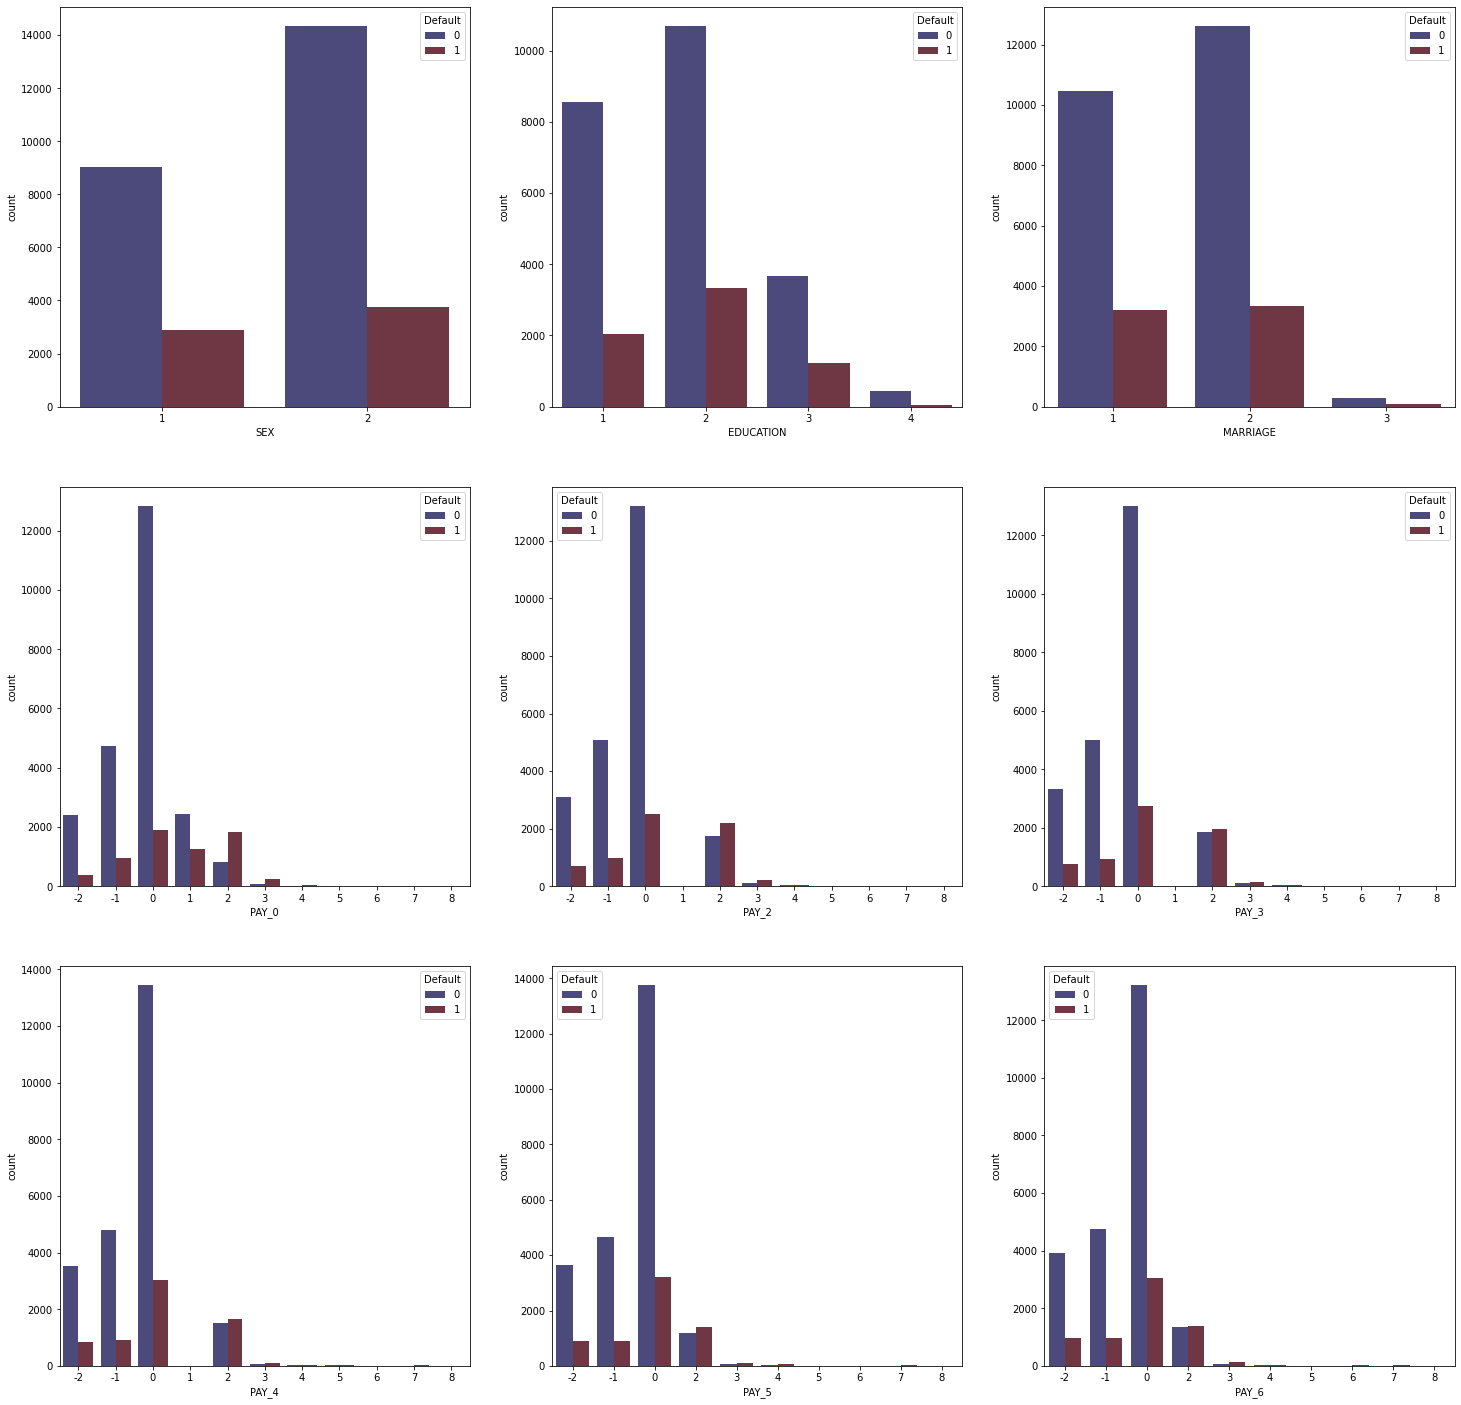

In [110]:
# Creating a new dataframe with categorical variables
subset = data[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'Default']]

f, axes = plt.subplots(3, 3, figsize=(25, 25), facecolor='white')
ax1 = sns.countplot(x="SEX", hue="Default", data=subset, palette="icefire", ax=axes[0,0])
ax2 = sns.countplot(x="EDUCATION", hue="Default", data=subset, palette="icefire",ax=axes[0,1])
ax3 = sns.countplot(x="MARRIAGE", hue="Default", data=subset, palette="icefire",ax=axes[0,2])
ax4 = sns.countplot(x="PAY_0", hue="Default", data=subset, palette="icefire", ax=axes[1,0])
ax5 = sns.countplot(x="PAY_2", hue="Default", data=subset, palette="icefire", ax=axes[1,1])
ax6 = sns.countplot(x="PAY_3", hue="Default", data=subset, palette="icefire", ax=axes[1,2])
ax7 = sns.countplot(x="PAY_4", hue="Default", data=subset, palette="icefire", ax=axes[2,0])
ax8 = sns.countplot(x="PAY_5", hue="Default", data=subset, palette="icefire", ax=axes[2,1])
ax9 = sns.countplot(x="PAY_6", hue="Default", data=subset, palette="icefire", ax=axes[2,2])

###Model Building

In [111]:
x = data.drop('Default', axis=1)  
y = data['Default']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=y, random_state=42)

In [112]:
sc_x = StandardScaler() 
x_std_train = sc_x.fit_transform(x_train)  
x_std_test = sc_x.transform(x_test) 

####Logistic Regression

##### 1. Using original data 

In [113]:
lrO = LogisticRegression(random_state = 0, max_iter =1000) 
lrO.fit(x_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
y_pred = lrO.predict(x_test) 

Confusion Matrix : 
 [[4673    0]
 [1327    0]]


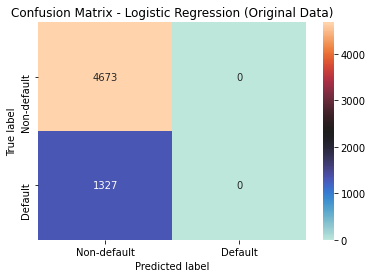

In [115]:
cm = confusion_matrix(y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 

sns.heatmap(cm ,annot=True, cmap="icefire", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression (Original Data)");

In [116]:
print ("Accuracy : ", accuracy_score(y_test, y_pred)*100, "%") 

Accuracy :  77.88333333333334 %


##### 2. Ussing Standardised features

In [117]:
lrStd = LogisticRegression(random_state = 0) 
lrStd.fit(x_std_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
y_pred = lrStd.predict(x_std_test) 

Confusion Matrix : 
 [[4526  147]
 [1005  322]]


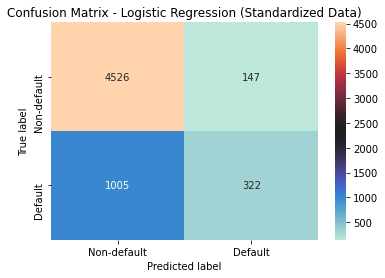

In [119]:
cm = confusion_matrix(y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 

sns.heatmap(cm ,annot=True, cmap="icefire", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression (Standardized Data)");

In [120]:
print ("Accuracy : ", accuracy_score(y_test, y_pred)*100, "%") 

Accuracy :  80.80000000000001 %


##### 3. Using Essential Features

In [121]:
lrRFE = LogisticRegression(random_state = 0)
no_features = 3
rfe_stand = RFE(lrRFE, no_features)
fit_stand = rfe_stand.fit(x_std_train, y_train)

In [122]:
feature_names = np.array(x.columns)
print("Std Model Feature Ranking:", fit_stand.ranking_)
print('imp features:', feature_names[rfe_stand.support_])

Std Model Feature Ranking: [ 5 12  8  7  9  1  6  3 10 21 19  1  1 17 11 15 20  2  4 13 14 18 16]
imp features: ['PAY_0' 'BILL_AMT1' 'BILL_AMT2']


In [123]:
ximp = x[['PAY_0', 'BILL_AMT1', 'BILL_AMT2']]
x_imp_train, x_imp_test, y_imp_train, y_imp_test = train_test_split(ximp, y, test_size=0.2, stratify=y, random_state=42)

x_imp_train = sc_x.fit_transform(x_imp_train)  
x_imp_test = sc_x.transform(x_imp_test) 

In [124]:
lrRFE.fit(x_imp_train, y_imp_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [125]:
y_imp_pred = lrRFE.predict(x_imp_test)

Confusion Matrix : 
 [[4513  160]
 [ 964  363]]


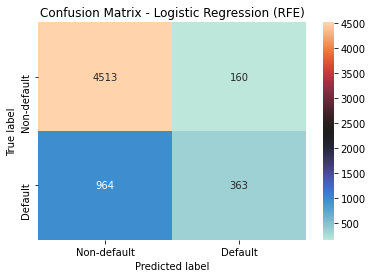

In [126]:
cm = confusion_matrix(y_imp_test, y_imp_pred) 
print ("Confusion Matrix : \n", cm) 

sns.heatmap(cm ,annot=True, cmap="icefire", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression (RFE)");

In [127]:
print ("Accuracy : ", accuracy_score(y_imp_test, y_imp_pred)*100, "%") 

Accuracy :  81.26666666666667 %


#### Decision Tree Classification

In [128]:
dtree = DecisionTreeClassifier()
dtree.fit(x_std_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [129]:
y_pred = dtree.predict(x_std_test)

Confusion Matrix : 
 [[3772  901]
 [ 801  526]]


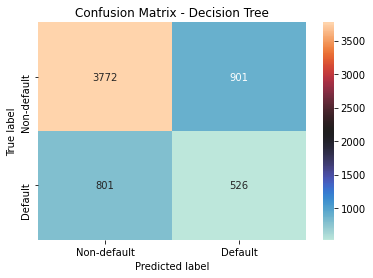

In [130]:
cm = confusion_matrix(y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 

sns.heatmap(cm ,annot=True, cmap="icefire", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Decision Tree");

In [131]:
print ("Accuracy : ", accuracy_score(y_test, y_pred)*100, "%") 

Accuracy :  71.63333333333334 %


#### Random Forest Classification

In [132]:
rf = RandomForestClassifier()
rf.fit(x_std_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [133]:
y_pred = rf.predict(x_std_test)

Confusion Matrix : 
 [[4396  277]
 [ 855  472]]


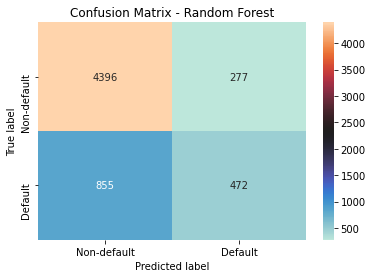

In [134]:
cm = confusion_matrix(y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 

sns.heatmap(cm ,annot=True, cmap="icefire", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

In [135]:
print ("Accuracy : ", accuracy_score(y_test, y_pred)*100, "%") 

Accuracy :  81.13333333333334 %


In [ ]:
param = {'n_estimators': [50,100,150,200,250],
         "max_features": [1,2,3,4,5,6,7,8,9],
         'max_depth': [1,2,3,4,5,6,7,8,9]}

rf_cv = RandomizedSearchCV(classifier, param_distributions = param, n_iter = 200, cv = 6, random_state=0, n_jobs = -1)

rf_cv.fit (x_std_train, y_train)
print("Tuned Random Forest Parameters : " , rf_cv.best_params_)

Tuned Random Forest Parameters :  {'n_estimators': 50, 'max_features': 7, 'max_depth': 7}


In [136]:
rf = RandomForestClassifier(max_depth= 5, max_features= 7, n_estimators= 200, random_state=0)
rf.fit(x_std_train, y_train)
y_pred = rf.predict(x_std_test)

Confusion Matrix : 
 [[4438  235]
 [ 862  465]]


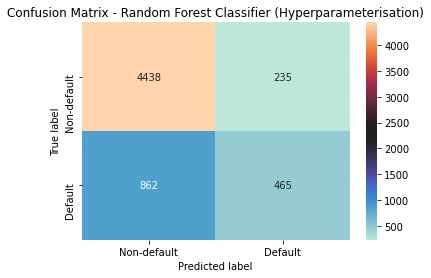

In [137]:
cm = confusion_matrix(y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 

sns.heatmap(cm ,annot=True, cmap="icefire", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest Classifier (Hyperparameterisation)");

In [138]:
print ("Accuracy : ", accuracy_score(y_test, y_pred)*100, "%")

Accuracy :  81.71666666666667 %


### Comparison of Model Performance

#### ROC Curve and AUC

In [139]:
y_pred_proba_RF = rf.predict_proba(x_std_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba_RF)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba_RF)

y_pred_proba_DT = dtree.predict_proba(x_std_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba_DT)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba_DT)

y_pred_proba_LR = lrO.predict_proba(x_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba_LR)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba_LR)

y_pred_proba_LRS = lrStd.predict_proba(x_std_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba_LRS)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba_LRS)

y_pred_proba_LRimp = lrRFE.predict_proba(x_imp_test)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_imp_test,  y_pred_proba_LRimp)
auc5 = metrics.roc_auc_score(y_imp_test, y_pred_proba_LRimp)

Text(0, 0.5, 'True Positive Rate (Recall)')

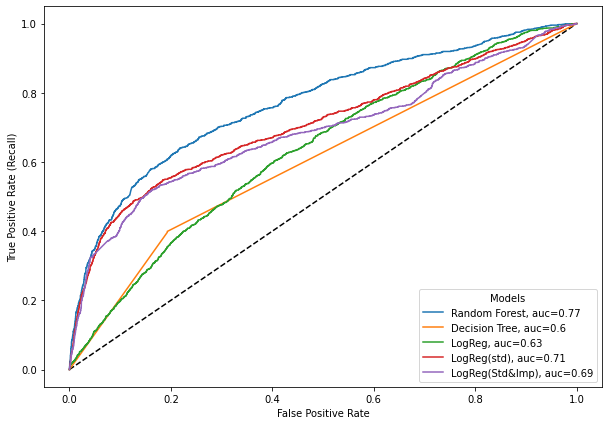

In [140]:
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1,tpr1,label="Random Forest, auc="+str(round(auc1,2)))
plt.plot(fpr2,tpr2,label="Decision Tree, auc="+str(round(auc2,2)))
plt.plot(fpr3,tpr3,label="LogReg, auc="+str(round(auc3,2)))
plt.plot(fpr4,tpr4,label="LogReg(std), auc="+str(round(auc4,2)))
plt.plot(fpr5,tpr5,label="LogReg(Std&Imp), auc="+str(round(auc5,2)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')

#### Cross Validation Accuracy

In [143]:
cv_results_lrO = cross_val_score(lrO , x_train, y_train, scoring = 'accuracy')
print ("Logistic Regression using original data : ", cv_results_lrO.mean())

cv_results_lrStd = cross_val_score(lrStd , x_std_train, y_train, scoring = 'accuracy')
print ("Logistic Regression using standardized data : ", cv_results_lrStd.mean())

cv_results_lrRFE = cross_val_score(lrRFE , x_imp_train, y_imp_train, scoring = 'accuracy')
print ("Logistic Regression using RFE data : ", cv_results_lrRFE.mean())

cv_results_dt = cross_val_score(dtree , x_std_train, y_train, scoring = 'accuracy')
print ("Decision Tree using standardised data : ", cv_results_dt.mean())

cv_results_rf = cross_val_score(rf , x_std_train, y_train, scoring = 'accuracy')
print ("Random Forest using original data : ", cv_results_rf.mean())

Logistic Regression using original data :  0.7787916666666667
Logistic Regression using standardized data :  0.8112916666666667
Logistic Regression using RFE data :  0.8129583333333332
Decision Tree using standardised data :  0.7277916666666667
Random Forest using original data :  0.8221666666666667


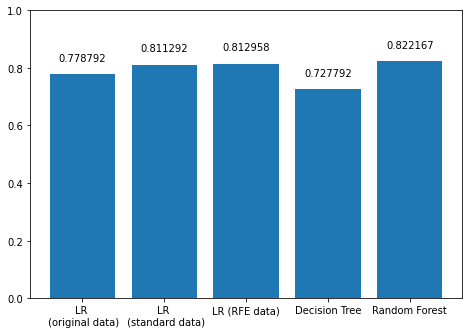

In [144]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0,1])
models = ['LR \n (original data)', 'LR \n (standard data)', 'LR (RFE data)', 'Decision Tree', 'Random Forest']
accuracy = [cv_results_lrO.mean(), cv_results_lrStd.mean(), cv_results_lrRFE.mean(), cv_results_dt.mean(), cv_results_rf.mean()]
temp = ax.bar(models, accuracy)
for t in temp:
        height = t.get_height()
        ax.text(t.get_x() + t.get_width()/2., 1.05*height, '%f' % float(height), ha='center', va='bottom')
plt.show()